In [1]:
import pandas as pd

df = pd.read_csv("../data/data_for_modelling.csv")

Before: (135231, 14)
After: (135206, 14)


,visit_count,intake_type,intake_condition,animal_type,breed,color,outcome_type,HasName,age_days_intake,intake_month_num,intake_weekday_num,intake_hour,intactness,sex
0,3,Stray,Normal,Dog,Spinone Italiano Mix,Yellow/White,Return to Owner,1,3650,12,3,14,not_intact,male
1,1,Owner Surrender,Normal,Dog,Dachshund,Tricolor,Transfer,1,3650,4,2,15,not_intact,male
2,1,Public Assist,Injured,Dog,Shetland Sheepdog,Brown/White,Return to Owner,1,5840,11,5,9,not_intact,male
3,1,Stray,Aged,Dog,Labrador Retriever/Pit Bull,Black/White,Return to Owner,1,5475,11,5,14,not_intact,female
4,1,Stray,Normal,Dog,Miniature Schnauzer Mix,Black/Gray,Return to Owner,1,5475,11,4,15,intact,female
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135226,1,Stray,Neonatal,Cat,Domestic Shorthair,Brown Tabby,Transfer,0,4,5,4,12,unknown,unknown
135227,1,Stray,Neonatal,Cat,Domestic Shorthair,Brown Tabby,Transfer,0,4,5,4,12,unknown,unknown
135228,1,Stray,Neonatal,Cat,Domestic Shorthair,Brown Tabby,Transfer,0,4,5,4,12,unknown,unknown
135229,1,Stray,Normal,Cat,Domestic Shorthair,Black,Transfer,0,365,5,4,12,unknown,unknown


In [2]:
df_sampled = df.sample(frac=0.1, random_state=42).reset_index(drop=True)
df_sampled

,visit_count,intake_type,intake_condition,animal_type,breed,color,outcome_type,HasName,age_days_intake,intake_month_num,intake_weekday_num,intake_hour,intactness,sex
0,1,Stray,Normal,Dog,Pug/Beagle,Tan/White,Adoption,0,180,6,0,13,intact,male
1,1,Stray,Normal,Cat,Domestic Shorthair Mix,Black/White,Adoption,0,60,10,3,12,intact,male
2,1,Stray,Sick,Cat,Domestic Shorthair,Flame Point,Adoption,1,60,7,4,12,intact,female
3,2,Owner Surrender,Normal,Dog,Australian Cattle Dog Mix,White/Brown,Transfer,1,2190,4,5,12,not_intact,female
4,1,Stray,Normal,Dog,Labrador Retriever,Black/White,Adoption,1,150,5,2,11,intact,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13516,1,Stray,Normal,Dog,Miniature Pinscher/Pug,Tricolor,Adoption,1,365,7,0,13,intact,female
13517,1,Stray,Normal,Cat,Domestic Shorthair Mix,Tortie,Transfer,1,30,6,1,10,intact,female
13518,1,Stray,Normal,Cat,Domestic Shorthair,Black,Adoption,1,30,7,1,16,not_intact,female
13519,1,Owner Surrender,Normal,Cat,Himalayan Mix,Tortie Point/White,Adoption,1,3650,2,6,10,not_intact,female


In [3]:
df_sampled.columns
print(df_sampled['outcome_type'].value_counts())

outcome_type
Adoption           6418
Transfer           4521
Return to Owner    1972
Euthanasia          452
Died                130
Other                28
Name: count, dtype: int64


In [4]:
data_for_modelling = df_sampled

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score
from sklearn.utils.class_weight import compute_class_weight
import pickle
from datetime import datetime

# ============================================================================
# CONFIGURATION
# ============================================================================

RANDOM_STATES = [1, 2, 3, 4, 5]
TRAIN_SIZE = 0.6
VAL_SIZE = 0.5

C_VALUES = np.logspace(-4, 3, 8)  
L1_RATIOS = np.linspace(0, 1, 6) 

print("="*80)
print("LOGISTIC REGRESSION PIPELINE - ANIMAL SHELTER OUTCOME PREDICTION")
print("="*80)
print(f"\nConfiguration:")
print(f"  Penalty: ElasticNet (L1 + L2)")
print(f"  Random states: {RANDOM_STATES}")
print(f"  Train/Val/Test: {TRAIN_SIZE}/{(1-TRAIN_SIZE)*VAL_SIZE}/{(1-TRAIN_SIZE)*(1-VAL_SIZE)}")
print(f"  C values: {C_VALUES}")
print(f"  l1_ratio values: {L1_RATIOS}")
print(f"  Total combinations: {len(C_VALUES)} × {len(L1_RATIOS)} = {len(C_VALUES)*len(L1_RATIOS)}")

# ============================================================================
# PREPROCESSING FUNCTIONS
# ============================================================================

def encode_cyclical(X):
    """Transform cyclical features to sin/cos components."""
    if isinstance(X, pd.DataFrame):
        X = X.values
    
    periods = [12, 7, 24]
    result = []
    
    for i, period in enumerate(periods):
        values = X[:, i]
        result.append(np.sin(2 * np.pi * values / period).reshape(-1, 1))
        result.append(np.cos(2 * np.pi * values / period).reshape(-1, 1))
    
    return np.hstack(result)

def get_cyclical_feature_names(transformer, input_features):
    """Generate feature names for cyclical encoding output."""
    names = []
    for feature in input_features:
        names.append(f'{feature}_sin')
        names.append(f'{feature}_cos')
    return np.array(names)

def create_preprocessor():
    """Create preprocessing pipeline."""
    onehot_ftrs = [
        'intake_type', 'intake_condition', 'animal_type', 'sex', 
        'intactness', 'breed', 'color', 'HasName'
    ]
    
    std_ftrs = ['visit_count', 'age_days_intake']
    
    cyclical_ftrs = ['intake_month_num', 'intake_weekday_num', 'intake_hour']
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('onehot', OneHotEncoder(
                sparse_output=False, 
                handle_unknown='ignore'
            ), onehot_ftrs),
            
            ('std', StandardScaler(), std_ftrs),
            
            ('cyclical', FunctionTransformer(
                encode_cyclical, 
                validate=False,
                feature_names_out=get_cyclical_feature_names
            ), cyclical_ftrs)
        ],
        verbose_feature_names_out=False
    )
    
    return preprocessor

def macro_f2_score(y_true, y_pred):
    """Calculate macro-averaged F2 score."""
    return fbeta_score(y_true, y_pred, beta=2, average='macro')

def calculate_baseline(y_train, y_val, y_test):
    """Calculate baseline F2 by predicting most frequent class."""
    most_frequent = y_train.value_counts().idxmax()
    
    y_train_pred = np.full(len(y_train), most_frequent)
    y_val_pred = np.full(len(y_val), most_frequent)
    y_test_pred = np.full(len(y_test), most_frequent)
    
    return {
        'most_frequent_class': most_frequent,
        'train_f2': macro_f2_score(y_train, y_train_pred),
        'val_f2': macro_f2_score(y_val, y_val_pred),
        'test_f2': macro_f2_score(y_test, y_test_pred),
    }

# ============================================================================
# HYPERPARAMETER TUNING
# ============================================================================

def tune_hyperparameters(X_train_prep, y_train, X_val_prep, y_val, class_weight_dict, random_state):
    """
    Test all hyperparameter combinations.
    Returns best model (already trained) and tuning results.
    """
    best_val_f2 = -np.inf
    best_model = None
    best_params = None
    
    tune_results = []
    
    total_combos = len(C_VALUES) * len(L1_RATIOS)
    print(f"\n  Testing {total_combos} combinations...")
    
    combo_num = 0
    for C in C_VALUES:
        for l1_ratio in L1_RATIOS:
            combo_num += 1
            print(f"    [{combo_num}/{total_combos}] Testing C={C:.5f}, l1_ratio={l1_ratio:.2f}...", end='', flush=True)
            
            # Train model
            clf = LogisticRegression(
                penalty='elasticnet',
                solver='saga',
                C=C,
                l1_ratio=l1_ratio,
                class_weight=class_weight_dict,
                max_iter=1000,
                random_state=random_state,
                n_jobs=-1,
            )
            
            clf.fit(X_train_prep, y_train)
            
            # Evaluate
            y_train_pred = clf.predict(X_train_prep)
            y_val_pred = clf.predict(X_val_prep)
            
            train_f2 = macro_f2_score(y_train, y_train_pred)
            val_f2 = macro_f2_score(y_val, y_val_pred)
            
            print(f" Train F2={train_f2:.4f}, Val F2={val_f2:.4f}", flush=True)
            
            # Store results
            tune_results.append({
                'C': C,
                'l1_ratio': l1_ratio,
                'train_f2': train_f2,
                'val_f2': val_f2,
            })
            
            # Track best model
            if val_f2 > best_val_f2:
                best_val_f2 = val_f2
                best_model = clf  # Keep the trained model
                best_params = {'C': C, 'l1_ratio': l1_ratio}
    
    print(f"\n  ✓ Best: C={best_params['C']:.5f}, l1_ratio={best_params['l1_ratio']:.2f}, Val F2={best_val_f2:.4f}")
    
    return best_model, best_params, tune_results

# ============================================================================
# MAIN EXPERIMENT
# ============================================================================

def run_experiment(data_for_modelling, random_state):
    """Run complete experiment for one random state."""
    
    print(f"\n{'='*80}")
    print(f"Random State: {random_state}")
    print(f"{'='*80}")
    
    # Separate features and target
    y = data_for_modelling['outcome_type']
    X = data_for_modelling.drop(columns=['outcome_type'])
    
    # Split data
    X_train, X_other, y_train, y_other = train_test_split(
        X, y, train_size=TRAIN_SIZE, stratify=y, random_state=random_state, shuffle=True
    )
    
    X_val, X_test, y_val, y_test = train_test_split(
        X_other, y_other, train_size=VAL_SIZE, stratify=y_other, random_state=random_state, shuffle=True
    )
    
    print(f"\nData splits: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")
    
    # Calculate baseline
    baseline = calculate_baseline(y_train, y_val, y_test)
    print(f"\nBaseline (predicting '{baseline['most_frequent_class']}'):")
    print(f"  Train F2: {baseline['train_f2']:.4f}")
    print(f"  Val F2:   {baseline['val_f2']:.4f}")
    print(f"  Test F2:  {baseline['test_f2']:.4f}")
    
    # Compute class weights
    classes = np.unique(y_train)
    class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weight_dict = dict(zip(classes, class_weights))
    
    print(f"\nClass weights:")
    for cls in sorted(class_weight_dict.keys()):
        print(f"  {cls:20s}: {class_weight_dict[cls]:.4f} (n={sum(y_train==cls)})")
    
    # Preprocess
    preprocessor = create_preprocessor()
    preprocessor.fit(X_train)
    
    X_train_prep = preprocessor.transform(X_train)
    X_val_prep = preprocessor.transform(X_val)
    X_test_prep = preprocessor.transform(X_test)
    
    feature_names = preprocessor.get_feature_names_out()
    print(f"\nFeatures after preprocessing: {len(feature_names)}")
    
    # Tune hyperparameters (returns best model already trained)
    best_model, best_params, tune_results = tune_hyperparameters(
        X_train_prep, y_train, X_val_prep, y_val, class_weight_dict, random_state
    )
    
    # Get predictions from best model (no retraining)
    y_train_pred = best_model.predict(X_train_prep)
    y_val_pred = best_model.predict(X_val_prep)
    y_test_pred = best_model.predict(X_test_prep)
    
    # Calculate final scores
    train_f2 = macro_f2_score(y_train, y_train_pred)
    val_f2 = macro_f2_score(y_val, y_val_pred)
    test_f2 = macro_f2_score(y_test, y_test_pred)
    
    print(f"\nFinal Macro F2 Scores:")
    print(f"  Train: {train_f2:.4f} (baseline: {baseline['train_f2']:.4f}, Δ: +{train_f2-baseline['train_f2']:.4f})")
    print(f"  Val:   {val_f2:.4f} (baseline: {baseline['val_f2']:.4f}, Δ: +{val_f2-baseline['val_f2']:.4f})")
    print(f"  Test:  {test_f2:.4f} (baseline: {baseline['test_f2']:.4f}, Δ: +{test_f2-baseline['test_f2']:.4f})")
    
    # Return results
    return {
        'random_state': random_state,
        'best_model': best_model,
        'preprocessor': preprocessor,
        'feature_names': feature_names,
        'class_weight_dict': class_weight_dict,
        'best_params': best_params,
        'tune_results': tune_results,
        
        # Original data
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        
        # Preprocessed data
        'X_train_prep': X_train_prep,
        'X_val_prep': X_val_prep,
        'X_test_prep': X_test_prep,
        
        # Predictions
        'y_train_pred': y_train_pred,
        'y_val_pred': y_val_pred,
        'y_test_pred': y_test_pred,
        
        # Scores
        'train_f2': train_f2,
        'val_f2': val_f2,
        'test_f2': test_f2,
        'baseline': baseline,
    }

# ============================================================================
# RUN ALL EXPERIMENTS
# ============================================================================

all_results = []

for rs in RANDOM_STATES:
    result = run_experiment(data_for_modelling, rs)
    all_results.append(result)

# ============================================================================
# AGGREGATE RESULTS
# ============================================================================

print("\n" + "="*80)
print("AGGREGATE RESULTS")
print("="*80)

test_f2_scores = [r['test_f2'] for r in all_results]

print(f"\nTest Macro F2 Scores:")
print(f"  Mean: {np.mean(test_f2_scores):.4f}")
print(f"  Std:  {np.std(test_f2_scores):.4f}")
print(f"  Min:  {np.min(test_f2_scores):.4f}")
print(f"  Max:  {np.max(test_f2_scores):.4f}")

baseline_test = np.mean([r['baseline']['test_f2'] for r in all_results])
print(f"\nBaseline Test F2: {baseline_test:.4f}")
print(f"Improvement: +{np.mean(test_f2_scores) - baseline_test:.4f}")

LOGISTIC REGRESSION PIPELINE - ANIMAL SHELTER OUTCOME PREDICTION

Configuration:
  Penalty: ElasticNet (L1 + L2)
  Random states: [1, 2, 3, 4, 5]
  Train/Val/Test: 0.6/0.2/0.2
  C values: [1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]
  l1_ratio values: [0.  0.2 0.4 0.6 0.8 1. ]
  Total combinations: 8 × 6 = 48

Random State: 1

Data splits: Train=8112, Val=2704, Test=2705

Baseline (predicting 'Adoption'):
  Train F2: 0.1365
  Val F2:   0.1364
  Test F2:  0.1365

Class weights:
  Adoption            : 0.3511 (n=3851)
  Died                : 17.3333 (n=78)
  Euthanasia          : 4.9889 (n=271)
  Other               : 79.5294 (n=17)
  Return to Owner     : 1.1429 (n=1183)
  Transfer            : 0.4985 (n=2712)

Features after preprocessing: 978

  Testing 48 combinations...
    [1/48] Testing C=0.00010, l1_ratio=0.00... Train F2=0.2878, Val F2=0.2825
    [2/48] Testing C=0.00010, l1_ratio=0.20... Train F2=0.0077, Val F2=0.0077
    [3/48] Testing C=0.00010, l1_ratio=0.40... 

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 Train F2=0.3514, Val F2=0.3477
    [15/48] Testing C=0.01000, l1_ratio=0.40...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 Train F2=0.3458, Val F2=0.3314
    [16/48] Testing C=0.01000, l1_ratio=0.60... Train F2=0.3345, Val F2=0.3245
    [17/48] Testing C=0.01000, l1_ratio=0.80... Train F2=0.3326, Val F2=0.3186
    [18/48] Testing C=0.01000, l1_ratio=1.00... Train F2=0.3253, Val F2=0.3120
    [19/48] Testing C=0.10000, l1_ratio=0.00... Train F2=0.4092, Val F2=0.3285
    [20/48] Testing C=0.10000, l1_ratio=0.20...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 Train F2=0.3648, Val F2=0.3139
    [21/48] Testing C=0.10000, l1_ratio=0.40...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 Train F2=0.3246, Val F2=0.2703
    [22/48] Testing C=0.10000, l1_ratio=0.60...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 Train F2=0.3152, Val F2=0.2775
    [23/48] Testing C=0.10000, l1_ratio=0.80... Train F2=0.3560, Val F2=0.3117
    [24/48] Testing C=0.10000, l1_ratio=1.00... Train F2=0.4103, Val F2=0.3561
    [25/48] Testing C=1.00000, l1_ratio=0.00... Train F2=0.3784, Val F2=0.2999
    [26/48] Testing C=1.00000, l1_ratio=0.20... Train F2=0.3779, Val F2=0.2976
    [27/48] Testing C=1.00000, l1_ratio=0.40... Train F2=0.3774, Val F2=0.2987
    [28/48] Testing C=1.00000, l1_ratio=0.60... Train F2=0.4198, Val F2=0.3238
    [29/48] Testing C=1.00000, l1_ratio=0.80... Train F2=0.4169, Val F2=0.3361
    [30/48] Testing C=1.00000, l1_ratio=1.00... Train F2=0.4326, Val F2=0.3446
    [31/48] Testing C=10.00000, l1_ratio=0.00... Train F2=0.4203, Val F2=0.3358
    [32/48] Testing C=10.00000, l1_ratio=0.20... Train F2=0.4202, Val F2=0.3361
    [33/48] Testing C=10.00000, l1_ratio=0.40... Train F2=0.4195, Val F2=0.3365
    [34/48] Testing C=10.00000, l1_ratio=0.60... Train F2=0.4197, Val F2=0.3362
    [35/48] Test

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 Train F2=0.3727, Val F2=0.3242
    [21/48] Testing C=0.10000, l1_ratio=0.40... Train F2=0.3494, Val F2=0.3124
    [22/48] Testing C=0.10000, l1_ratio=0.60...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 Train F2=0.3646, Val F2=0.3287
    [23/48] Testing C=0.10000, l1_ratio=0.80... Train F2=0.3709, Val F2=0.3319
    [24/48] Testing C=0.10000, l1_ratio=1.00... Train F2=0.3543, Val F2=0.3235
    [25/48] Testing C=1.00000, l1_ratio=0.00... Train F2=0.3996, Val F2=0.3286
    [26/48] Testing C=1.00000, l1_ratio=0.20... Train F2=0.3991, Val F2=0.3288
    [27/48] Testing C=1.00000, l1_ratio=0.40... Train F2=0.3968, Val F2=0.3259
    [28/48] Testing C=1.00000, l1_ratio=0.60... Train F2=0.3959, Val F2=0.3273
    [29/48] Testing C=1.00000, l1_ratio=0.80... Train F2=0.3937, Val F2=0.3275
    [30/48] Testing C=1.00000, l1_ratio=1.00... Train F2=0.3905, Val F2=0.3260
    [31/48] Testing C=10.00000, l1_ratio=0.00... Train F2=0.3947, Val F2=0.3317
    [32/48] Testing C=10.00000, l1_ratio=0.20... Train F2=0.3945, Val F2=0.3322
    [33/48] Testing C=10.00000, l1_ratio=0.40... Train F2=0.3944, Val F2=0.3323
    [34/48] Testing C=10.00000, l1_ratio=0.60... Train F2=0.3944, Val F2=0.3324
    [35/48] Test

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 Train F2=0.3629, Val F2=0.3547
    [15/48] Testing C=0.01000, l1_ratio=0.40... Train F2=0.3459, Val F2=0.3369
    [16/48] Testing C=0.01000, l1_ratio=0.60... Train F2=0.3516, Val F2=0.3491
    [17/48] Testing C=0.01000, l1_ratio=0.80... Train F2=0.3396, Val F2=0.3399
    [18/48] Testing C=0.01000, l1_ratio=1.00... Train F2=0.3428, Val F2=0.3474
    [19/48] Testing C=0.10000, l1_ratio=0.00... Train F2=0.3948, Val F2=0.3386
    [20/48] Testing C=0.10000, l1_ratio=0.20...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 Train F2=0.3963, Val F2=0.3492
    [21/48] Testing C=0.10000, l1_ratio=0.40...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 Train F2=0.3680, Val F2=0.3580
    [22/48] Testing C=0.10000, l1_ratio=0.60...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 Train F2=0.3719, Val F2=0.3297
    [23/48] Testing C=0.10000, l1_ratio=0.80...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 Train F2=0.4204, Val F2=0.3524
    [24/48] Testing C=0.10000, l1_ratio=1.00... Train F2=0.3715, Val F2=0.3261
    [25/48] Testing C=1.00000, l1_ratio=0.00... Train F2=0.4198, Val F2=0.3342
    [26/48] Testing C=1.00000, l1_ratio=0.20... Train F2=0.3726, Val F2=0.2974
    [27/48] Testing C=1.00000, l1_ratio=0.40... Train F2=0.4250, Val F2=0.3338
    [28/48] Testing C=1.00000, l1_ratio=0.60... Train F2=0.3931, Val F2=0.3219
    [29/48] Testing C=1.00000, l1_ratio=0.80... Train F2=0.4013, Val F2=0.3254
    [30/48] Testing C=1.00000, l1_ratio=1.00... Train F2=0.3809, Val F2=0.3149
    [31/48] Testing C=10.00000, l1_ratio=0.00... Train F2=0.3944, Val F2=0.3091
    [32/48] Testing C=10.00000, l1_ratio=0.20... Train F2=0.3953, Val F2=0.3094
    [33/48] Testing C=10.00000, l1_ratio=0.40... Train F2=0.3956, Val F2=0.3104
    [34/48] Testing C=10.00000, l1_ratio=0.60... Train F2=0.3937, Val F2=0.3083
    [35/48] Testing C=10.00000, l1_ratio=0.80... Train F2=0.3955, Val F2=0.3065
    [36/48] Tes

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 Train F2=0.3546, Val F2=0.3453
    [15/48] Testing C=0.01000, l1_ratio=0.40... Train F2=0.3502, Val F2=0.3432
    [16/48] Testing C=0.01000, l1_ratio=0.60... Train F2=0.3368, Val F2=0.3290
    [17/48] Testing C=0.01000, l1_ratio=0.80... Train F2=0.3247, Val F2=0.3200
    [18/48] Testing C=0.01000, l1_ratio=1.00... Train F2=0.3322, Val F2=0.3362
    [19/48] Testing C=0.10000, l1_ratio=0.00... Train F2=0.4114, Val F2=0.3417
    [20/48] Testing C=0.10000, l1_ratio=0.20...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 Train F2=0.4014, Val F2=0.3522
    [21/48] Testing C=0.10000, l1_ratio=0.40... Train F2=0.3988, Val F2=0.3480
    [22/48] Testing C=0.10000, l1_ratio=0.60... Train F2=0.3813, Val F2=0.3540
    [23/48] Testing C=0.10000, l1_ratio=0.80... Train F2=0.3808, Val F2=0.3431
    [24/48] Testing C=0.10000, l1_ratio=1.00... Train F2=0.3853, Val F2=0.3433
    [25/48] Testing C=1.00000, l1_ratio=0.00... Train F2=0.4193, Val F2=0.3491
    [26/48] Testing C=1.00000, l1_ratio=0.20... Train F2=0.4170, Val F2=0.3399
    [27/48] Testing C=1.00000, l1_ratio=0.40... Train F2=0.4141, Val F2=0.3394
    [28/48] Testing C=1.00000, l1_ratio=0.60... Train F2=0.4284, Val F2=0.3425
    [29/48] Testing C=1.00000, l1_ratio=0.80... Train F2=0.4273, Val F2=0.3428
    [30/48] Testing C=1.00000, l1_ratio=1.00... Train F2=0.4256, Val F2=0.3430
    [31/48] Testing C=10.00000, l1_ratio=0.00... Train F2=0.4348, Val F2=0.3380
    [32/48] Testing C=10.00000, l1_ratio=0.20... Train F2=0.4346, Val F2=0.3379
    [33/48] Testin

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 Train F2=0.3532, Val F2=0.3332
    [15/48] Testing C=0.01000, l1_ratio=0.40...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 Train F2=0.3461, Val F2=0.3264
    [16/48] Testing C=0.01000, l1_ratio=0.60... Train F2=0.3423, Val F2=0.3318
    [17/48] Testing C=0.01000, l1_ratio=0.80... Train F2=0.3347, Val F2=0.3287
    [18/48] Testing C=0.01000, l1_ratio=1.00... Train F2=0.3315, Val F2=0.3216
    [19/48] Testing C=0.10000, l1_ratio=0.00... Train F2=0.4183, Val F2=0.3480
    [20/48] Testing C=0.10000, l1_ratio=0.20...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 Train F2=0.3854, Val F2=0.3359
    [21/48] Testing C=0.10000, l1_ratio=0.40...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 Train F2=0.3837, Val F2=0.3365
    [22/48] Testing C=0.10000, l1_ratio=0.60...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 Train F2=0.3515, Val F2=0.3057
    [23/48] Testing C=0.10000, l1_ratio=0.80...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 Train F2=0.3756, Val F2=0.3240
    [24/48] Testing C=0.10000, l1_ratio=1.00...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 Train F2=0.3568, Val F2=0.3106
    [25/48] Testing C=1.00000, l1_ratio=0.00... Train F2=0.4126, Val F2=0.3082
    [26/48] Testing C=1.00000, l1_ratio=0.20... Train F2=0.3902, Val F2=0.3047
    [27/48] Testing C=1.00000, l1_ratio=0.40... Train F2=0.4369, Val F2=0.3368
    [28/48] Testing C=1.00000, l1_ratio=0.60...

C:\Users\Vinayak Mokashi\anaconda3\envs\data1030\Lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


 Train F2=0.4084, Val F2=0.3126
    [29/48] Testing C=1.00000, l1_ratio=0.80... Train F2=0.4210, Val F2=0.3359
    [30/48] Testing C=1.00000, l1_ratio=1.00... Train F2=0.3725, Val F2=0.2922
    [31/48] Testing C=10.00000, l1_ratio=0.00... Train F2=0.4185, Val F2=0.3164
    [32/48] Testing C=10.00000, l1_ratio=0.20... Train F2=0.4584, Val F2=0.3541
    [33/48] Testing C=10.00000, l1_ratio=0.40... Train F2=0.4386, Val F2=0.3526
    [34/48] Testing C=10.00000, l1_ratio=0.60... Train F2=0.4245, Val F2=0.3131
    [35/48] Testing C=10.00000, l1_ratio=0.80... Train F2=0.4076, Val F2=0.3019
    [36/48] Testing C=10.00000, l1_ratio=1.00... Train F2=0.3548, Val F2=0.2816
    [37/48] Testing C=100.00000, l1_ratio=0.00... Train F2=0.4199, Val F2=0.3120
    [38/48] Testing C=100.00000, l1_ratio=0.20... Train F2=0.4072, Val F2=0.3041
    [39/48] Testing C=100.00000, l1_ratio=0.40... Train F2=0.4299, Val F2=0.3212
    [40/48] Testing C=100.00000, l1_ratio=0.60... Train F2=0.4042, Val F2=0.2965
    [4

In [10]:
# Get the row with the highest validation F2
best_row = tune_summary.loc[tune_summary['val_f2'].idxmax()]

print(best_row)

# This is the best model with the best average validation score across random states.

C           0.010000
l1_ratio    0.200000
train_f2    0.354787
val_f2      0.342549
Name: 13, dtype: float64



CREATING HEATMAP PLOTS


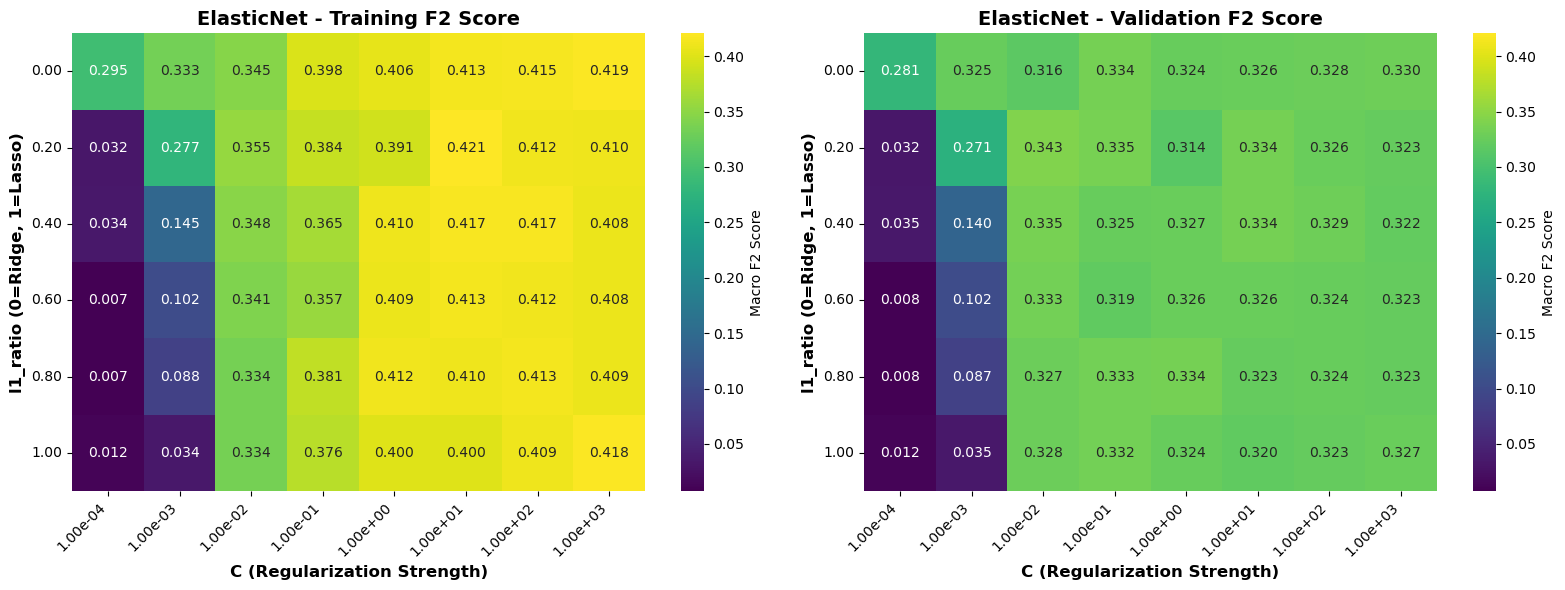


✓Saved: hyperparameter_heatmaps_elasticnet.png


In [8]:
# ============================================================================
# CREATE HEATMAP PLOTS
# ============================================================================

print(f"\n{'='*80}")
print("CREATING HEATMAP PLOTS")
print(f"{'='*80}")

# Aggregate tuning results
all_tune_data = []
for result in all_results:
    for tune_result in result['tune_results']:
        all_tune_data.append(tune_result)

tune_df = pd.DataFrame(all_tune_data)

# Average across random states for each combination
tune_summary = tune_df.groupby(['C', 'l1_ratio']).agg({
    'train_f2': 'mean',
    'val_f2': 'mean',
}).reset_index()

# Create pivot tables for heatmaps
train_pivot = tune_summary.pivot(index='l1_ratio', columns='C', values='train_f2')
val_pivot   = tune_summary.pivot(index='l1_ratio', columns='C', values='val_f2')

# Determine common color scale for fair comparison
vmin = min(train_pivot.min().min(), val_pivot.min().min())
vmax = max(train_pivot.max().max(), val_pivot.max().max())

# Create side-by-side heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Heatmap 1: Training F2
sns.heatmap(
    train_pivot, ax=axes[0], cmap='viridis',
    vmin=vmin, vmax=vmax,
    annot=True, fmt='.3f',
    cbar_kws={'label': 'Macro F2 Score'}
)
axes[0].set_title('ElasticNet - Training F2 Score', fontsize=14, fontweight='bold')
axes[0].set_xlabel('C (Regularization Strength)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('l1_ratio (0=Ridge, 1=Lasso)', fontsize=12, fontweight='bold')

# Heatmap 2: Validation F2
sns.heatmap(
    val_pivot, ax=axes[1], cmap='viridis',
    vmin=vmin, vmax=vmax,
    annot=True, fmt='.3f',
    cbar_kws={'label': 'Macro F2 Score'}
)
axes[1].set_title('ElasticNet - Validation F2 Score', fontsize=14, fontweight='bold')
axes[1].set_xlabel('C (Regularization Strength)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('l1_ratio (0=Ridge, 1=Lasso)', fontsize=12, fontweight='bold')

# Format ticks to look pretty (same grid for both since Cs/l1_ratios are shared)
for ax in axes:
    ax.set_xticklabels([f'{x:.2e}' for x in train_pivot.columns], rotation=45, ha='right')
    ax.set_yticklabels([f'{y:.2f}' for y in train_pivot.index], rotation=0)

plt.tight_layout()
plt.savefig('../figures/hyperparameter_heatmaps_elasticnet.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓Saved: hyperparameter_heatmaps_elasticnet.png")


In [12]:
# ============================================================================
# SAVE RESULTS
# ============================================================================

print(f"\n{'='*80}")
print("SAVING RESULTS")
print(f"{'='*80}")

final_results = {
    'all_results': all_results,
    'config': {
        'penalty': 'elasticnet',
        'random_states': RANDOM_STATES,
        'C_values': C_VALUES.tolist(),
        'l1_ratios': L1_RATIOS.tolist(),
    },
    'test_scores': {
        'mean': np.mean(test_f2_scores),
        'std': np.std(test_f2_scores),
        'all': test_f2_scores,
    },
    'timestamp': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

output_file = '../results/pipeline_results_elasticnet.pkl'
with open(output_file, 'wb') as f:
    pickle.dump(final_results, f)

print(f"\n✓ Saved to: {output_file}")
print(f"\nSaved components:")
print(f"  • 5 best models (one per random state)")
print(f"  • All data splits (original and preprocessed)")
print(f"  • Feature names")
print(f"  • All predictions (for confusion matrix)")
print(f"  • Hyperparameter tuning results (36 combinations × 5 states)")
print(f"  • Class weights")
print(f"  • Preprocessor objects")

print(f"\n{'='*80}")
print("PIPELINE COMPLETE!")
print(f"{'='*80}")


SAVING RESULTS

✓ Saved to: pipeline_results_elasticnet.pkl

Saved components:
  • 5 best models (one per random state)
  • All data splits (original and preprocessed)
  • Feature names
  • All predictions (for confusion matrix)
  • Hyperparameter tuning results (36 combinations × 5 states)
  • Class weights
  • Preprocessor objects

PIPELINE COMPLETE!


In [3]:
import pickle
import pandas as pd
import numpy as np

# ============================================================================
# LOAD SAVED RESULTS
# ============================================================================
output_file = '../results/pipeline_results_elasticnet.pkl'

with open(output_file, 'rb') as f:
    final_results = pickle.load(f)

all_results = final_results['all_results']

# ============================================================================
# BUILD TUNING SUMMARY ACROSS RANDOM STATES
# ============================================================================
rows = []

for res in all_results:
    rs = res['random_state']
    for tr in res['tune_results']:
        rows.append({
            'random_state': rs,
            'C': tr['C'],
            'l1_ratio': tr['l1_ratio'],
            'val_f2': tr['val_f2'],
        })

tune_df = pd.DataFrame(rows)

# Aggregate: mean & std of val_f2 for each (C, l1_ratio)
tune_summary = (
    tune_df
    .groupby(['C', 'l1_ratio'], as_index=False)
    .agg(
        mean_val_f2=('val_f2', 'mean'),
        std_val_f2=('val_f2', 'std'),
        n_runs=('val_f2', 'size')
    )
)

# ============================================================================
# FIND BEST HYPERPARAMETERS (BY MEAN VAL F2 ACROSS RUNS)
# ============================================================================
best_row = tune_summary.loc[tune_summary['mean_val_f2'].idxmax()]

print("Best hyperparameters (by mean validation F2 across runs):")
print(f"  C        : {best_row['C']}")
print(f"  l1_ratio : {best_row['l1_ratio']}")
print(f"  Mean Val F2  : {best_row['mean_val_f2']:.4f}")
print(f"  Std  Val F2  : {best_row['std_val_f2']:.4f}")
print(f"  Runs used     : {int(best_row['n_runs'])}")

print(f"\nValidation F2 (mean ± std): "
      f"{best_row['mean_val_f2']:.4f} ± {best_row['std_val_f2']:.4f}")


Best hyperparameters (by mean validation F2 across runs):
  C        : 0.01
  l1_ratio : 0.2
  Mean Val F2  : 0.3425
  Std  Val F2  : 0.0098
  Runs used     : 5

Validation F2 (mean ± std): 0.3425 ± 0.0098


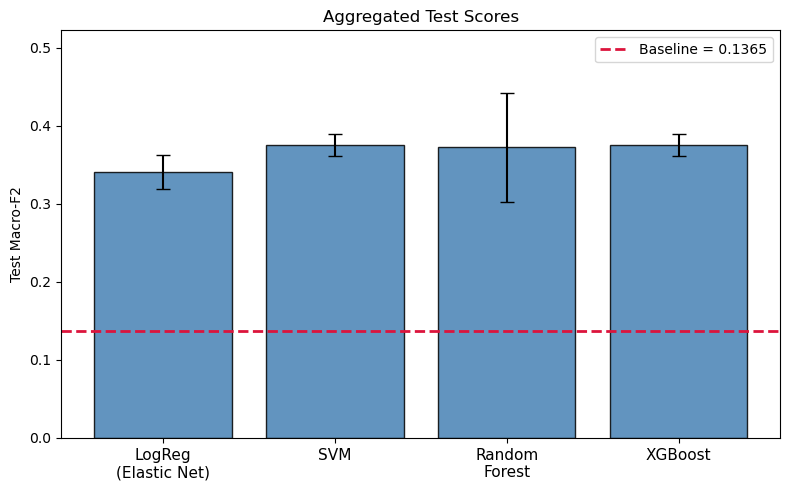

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Data
models = [
    "LogReg\n(Elastic Net)",
    "SVM",
    "Random\nForest",
    "XGBoost"
]

means = np.array([0.341, 0.375, 0.3723, 0.375])
stds  = np.array([0.022, 0.014, 0.070, 0.014])

baseline = 0.1365

# Plot
fig, ax = plt.subplots(figsize=(8, 5))

x = np.arange(len(models))

ax.bar(x, means, yerr=stds, capsize=5,
       alpha=0.85, color="steelblue", edgecolor="black")

# Baseline line in a different color
ax.axhline(
    baseline,
    linestyle="--",
    linewidth=2,
    color="crimson",
    label=f"Baseline = {baseline:.4f}"
)

ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=11)
ax.set_ylabel("Test Macro-F2")
ax.set_title("Aggregated Test Scores")
ax.set_ylim(0, max(means + stds) + 0.08)
ax.legend()

fig.tight_layout()

# Save (optional)
save_path = "../figures/aggregated_test_scores.png"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
fig.savefig(save_path, dpi=300, bbox_inches="tight")

plt.show()
